In [1]:
from parselog import *
lp = LogParser(
    log="results/capptr6-cap_ptr-l1/basicmath/sim_stdout.gz", 
    lineTypesToPrune=[None, NonRVFILine],
    # If a timestamped line matches, then either RVFILine or NonRVFILine will match
    lineTypesToError=[TimestampedLine],
    RootLogLine=TimestampedLine,
    startWhen=(lambda ll: isinstance(ll, RVFILine) and ll.rvfi >= 10000),
)

Loaded 1740625 log lines
	RVFILine:                     793613 instances
	CRqCreationLine:              394668 instances
	CRqHitLine:                   394667 instances
	PRqLine:                      3080 instances
	LLCRqHitLine:                 24613 instances
	CRqMissLine:                  3063 instances
	CapPtrCacheDataArrivalLine:   122423 instances
	CRqDependencyLine:            2858 instances
	CapPtrDataAddTTableEntryLine: 1112 instances
	CapPtrPTUpgradeLine:          376 instances
	CapPtrDataLookupPTableLine:   152 instances
Pre-processed 1740625 log lines
Post-processed 1740625 log lines
Accumulated totals and dists for 1740625 log lines


In [2]:
lp.printTotals()

RVFILine totals:
	total: 793613
	discard: 0

CRqCreationLine totals:
	total: 394667
	discard: 1
	Pr: 28
	Ld: 319621
	demand: 394639
	demandHit: 388719
	demandMiss: 3062
	demandMissLL: 3062
	demandOwned: 2858
	prefetch: 28
	prefetchHit: 27
	prefetchMiss: 1
	prefetchMissLL: 1
	prefetchOwned: 0
	latePrefetch: 0
	latePrefetchCreation: 0
	latePrefetchIssue: 0
	prefUnderPref: 0
	uselessPrefetch: 0
	uselessPrefetchBecausePerms: 0
	uselessPrefetchDisruption: 0
	prefetchDisruption: 0
	St: 75018
	discard(no cRq response): 1

CRqHitLine totals:
	total: 394667
	discard: 0

PRqLine totals:
	total: 3080
	discard: 0

LLCRqHitLine totals:
	total: 24613
	discard: 0

CRqMissLine totals:
	total: 3063
	discard: 0
	I --(St)--> M: 1149
	M --/St/--> M: 1
	I --(Ld)--> E: 1911
	E --/Ld/--> E: 1
	I --(Pr)--> S: 1

CapPtrCacheDataArrivalLine totals:
	total: 122423
	discard: 0

CRqDependencyLine totals:
	total: 2858
	discard: 0
	demand: 2858
	resolveHit: 2858
	resolveMiss: 0

CapPtrDataAddTTableEntryLine totals:


defaultdict(list,
            {4: Counter({'0xc00309f0': 294, '0xc0030b10': 9, '0xc00308f0': 4}),
             16: Counter({'0xc0030a40': 665}),
             8: Counter({'0xc00308e0': 83,
                      '0xc0030a30': 56,
                      '0xc00307e0': 1})})

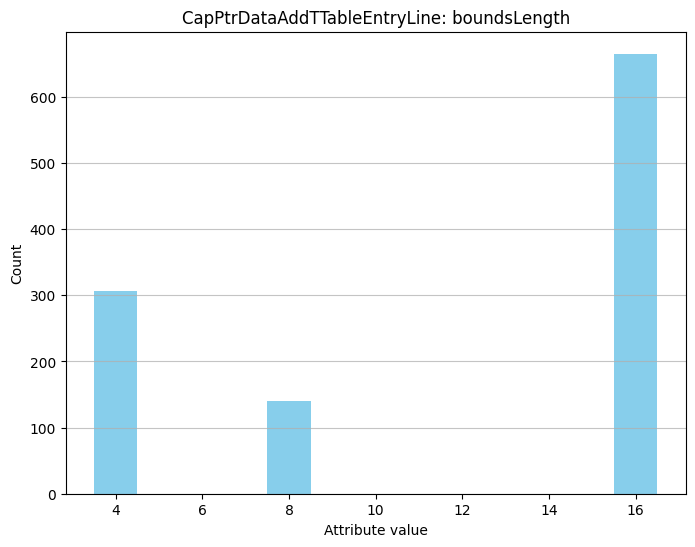

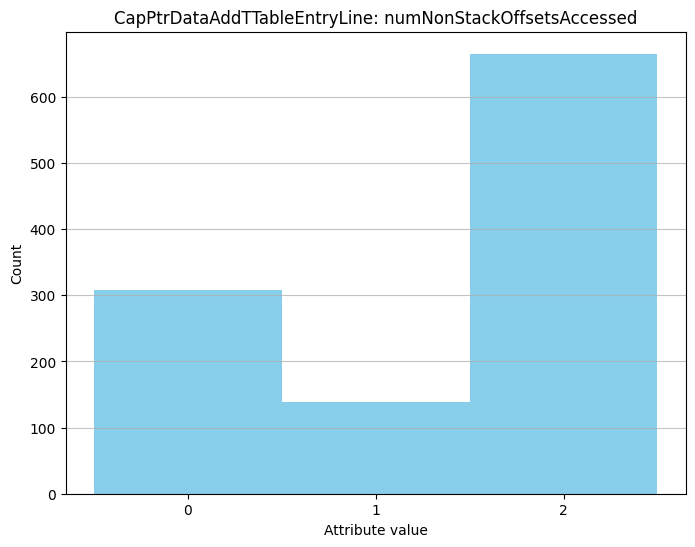

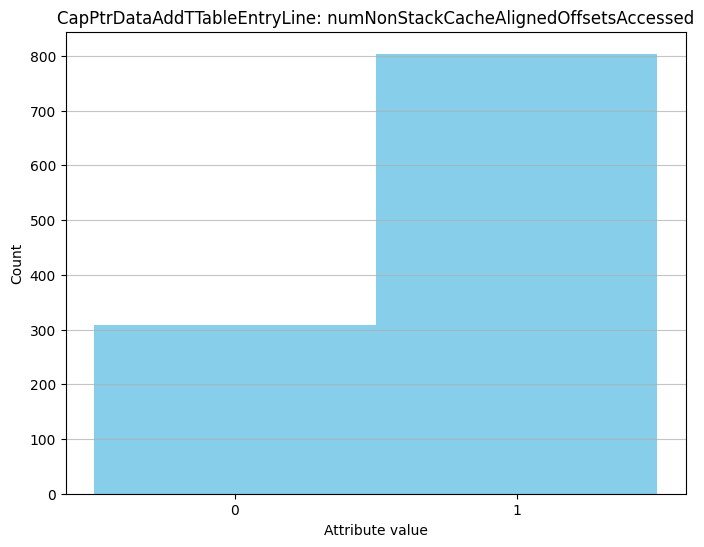

In [3]:
from collections import defaultdict

fig, ax = lp.plotDist(
    CapPtrDataAddTTableEntryLine,
    "boundsLength"
)

fig, ax = lp.plotDist(
    CapPtrDataAddTTableEntryLine,
    "numNonStackOffsetsAccessed"
)

fig, ax = lp.plotDist(
    CapPtrDataAddTTableEntryLine,
    "numNonStackCacheAlignedOffsetsAccessed"
)

d = defaultdict(list)
for ll in lp.logLines:
    if isinstance(ll, CapPtrDataAddTTableEntryLine):
        d[ll.boundsLength].append(hex(ll.addr))
for k, v in d.items():
    d[k] = Counter(d[k])
d

In [4]:
Counter(lp.dists[CRqCreationLine]["demandCapSize"])

Counter({3225419776: 222604,
         4: 144246,
         8: 18210,
         18446744073709551615: 7317,
         16: 1908,
         24: 264,
         128: 90})

In [5]:
Counter(lp.dists[CRqCreationLine]["demandHasPtrsCapSize"])

Counter({3225419776: 198483,
         4: 142429,
         8: 13174,
         16: 840,
         18446744073709551615: 404})

### For every prefetch CapPtr made for BasicMath:

- At what PC (ish) were they triggered? What instruction triggered them?
- What capability size triggered the prefetch?

In [6]:
import subprocess
objproc = subprocess.run(["/local/scratch/ldh35/bin/riscv-cheri-objdump", "-D", "--no-show-raw-insn", "/local/scratch/ldh35/mibench2/basicmath/basicmath.elf"], stdout=subprocess.PIPE)
obj = objproc.stdout.decode('utf-8').split("\n")
def getInstr(pc):
    hexpc = hex(pc).strip("0x").lstrip("0")
    for l in obj:
        if l.startswith(hexpc):
            return " ".join(l.split()[1:])

pcs = []
for i, ll in enumerate(lp.logLines):
    if isinstance(ll, CRqCreationLine) and ll.isPrefetch:
        trig = None
        trigTime = None
        info = None
        pcHash = None
        for j in range(i-1, i-100, -1):
            ll2 = lp.logLines[j]
            if isinstance(ll2, CapPtrDataLookupPTableLine) and not trig:
                trigTime = ll2.timestamp
                trig = ll2.addr
                info = ll2.capData
            if isinstance(ll2, CRqHitLine) and ll2.wasMiss and ll2.addr == trig:
                print(f"{ll2.cRqCreationLine.timestamp:8}: Triggering access")
                print(f"\t  PC: {hex(ll2.cRqCreationLine.pcHash)}")
                if hex(ll2.cRqCreationLine.pcHash) != "0xaaaaaaaa":
                    print(f"\tInst: {getInstr(ll2.cRqCreationLine.pcHash)}")
                else:
                    print(f"\t *PC: {hex(ll2.nextRvfiLine.pc)}")
                    print(f"\tInst: {getInstr(ll2.nextRvfiLine.pc)}")
                print(f"\tTrig: {hex(ll2.addr)}")
                print(f"\tBase: {hex(ll2.cRqCreationLine.boundsBase)}")
                print(f"\t Mod: {ll2.cRqCreationLine.boundsBase % 64}")
                print(f"\tOffs: {ll2.cRqCreationLine.boundsOffset}")
                print(f"\tSize: {ll2.cRqCreationLine.boundsLength}")
                print(f"\tMSHR: {ll2.cRqCreationLine.mshr}")
                print(f"{ll2.timestamp:8}: Data arrival")
                print(f"\tnCap: {ll2.nCap}")
                pcs.append(hex(ll2.cRqCreationLine.pcHash))
                pcHash = ll2.cRqCreationLine.pcHash
                break
        print(f"{trigTime:8}: Lookup occured")
        print(f"\tInfo: {info}")
        print(f"{ll.timestamp:8}: Prefetch creation\n\tPref: {hex(ll.addr)}")
        for j in range(i+1, i+100, 1):
            ll2 = lp.logLines[j]
            if isinstance(ll2, RVFILine) and ll2.pc == pcHash:
                print(f"{ll2.timestamp:8}: Trigger retire")
                print(f"\tLast PC: {hex(ll2.prevRvfiLine.pc)}")
                print(f"\t     TS: {ll2.prevRvfiLine.timestamp}")
                break
        print("\n\n")

        
for pc, c in Counter(sorted(pcs)).items():
    print(f"{pc}: {c}")

  194740: Triggering access
	  PC: 0xc000598e
	Inst: clw a2, 4(ca0)
	Trig: 0xc00308e4
	Base: 0xc00308e0
	 Mod: 32
	Offs: 4
	Size: 8
	MSHR: 0
  194834: Data arrival
	nCap: 4
  194834: Lookup occured
	Info: <V <'h0000816,v: True a: 'h00000000c00309f8 o: 'h0000000000000000 b: 'h00000000c00309f8 t: 'h000000000c00309fc sp: 'h000f hp: 'hffd ot: 'h3ffff f: 'h0,True> <'h0000817,v: True a: 'h00000000c00309f4 o: 'h0000000000000000 b: 'h00000000c00309f4 t: 'h000000000c00309f8 sp: 'h000f hp: 'hffd ot: 'h3ffff f: 'h0,True> <'h0000818,v: True a: 'h00000000c00309f0 o: 'h0000000000000000 b: 'h00000000c00309f0 t: 'h000000000c00309f4 sp: 'h000f hp: 'hffd ot: 'h3ffff f: 'h0,True> <'h0000819,v: True a: 'h00000000c00309ec o: 'h0000000000000000 b: 'h00000000c00309ec t: 'h000000000c00309f0 sp: 'h000f hp: 'hffd ot: 'h3ffff f: 'h0,True>  >
  194838: Prefetch creation
	Pref: 0xc00309f0
  194934: Trigger retire
	Last PC: 0xc000598a
	     TS: 194749



  222166: Triggering access
	  PC: 0xc0005992
	Inst: clw a0, 